# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
import imageio
from skimage.transform import resize
import datetime
import os

import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [5]:
def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Common Utils

Common utility to plot loss and accuracy

In [7]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    print("Max. Training Accuracy", max(history.history['categorical_accuracy']))
    print("Max. Validation Accuracy", max(history.history['val_categorical_accuracy']))

In [8]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [9]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
 #   filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
    
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
 #   checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]    

In [10]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Conv3d Models

### Model 1 - Frames-16, Epoc-20, Batch size-64

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
# from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras import optimizers

In [12]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 64
print ('# batch size =', batch_size)
num_frames = 16
print ('# num_frames per video =', num_frames)
num_images = num_frames
height = 120
width = 120

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=(num_images, height, width, 3)),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')     
], name="conv_3d1")

optimizer = tf.keras.optimizers.Adam() #write your optimizer
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model1.summary())

# epochs = 20
# batch size = 64
# num_frames per video = 16
Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 12, 116, 116, 16)  6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 58, 58, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 58, 58, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 56, 56, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 28, 28, 32)    0         
 3D)                                                            

2024-09-03 05:55:44.546937: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-03 05:55:44.547007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [13]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)
print(f'steps_per_epoch = {steps_per_epoch} - validation_steps = {validation_steps}')

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

steps_per_epoch = 11 - validation_steps = 2


In [14]:
model1_history = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/20


2024-09-03 05:55:56.250028: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.5551 - categorical_accuracy: 0.4480
Epoch 00001: val_loss improved from inf to 8.19119, saving model to model_conv3D_1_2024-09-0305_55_43.766329/model-00001-1.55511-0.44796-8.19119-0.23000.h5
11/11 [==============================] - 116s 11s/step - loss: 1.5551 - categorical_accuracy: 0.4480 - val_loss: 8.1912 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.8151 - categorical_accuracy: 0.6893
Epoch 00002: val_loss improved from 8.19119 to 6.75948, saving model to model_conv3D_1_2024-09-0305_55_43.766329/model-00002-0.81510-0.68929-6.75948-0.18000.h5
11/11 [==============================] - 106s 11s/step - loss: 0.8151 - categorical_accuracy: 0.6893 - val_loss: 6.7595 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.5623 - categorical_accuracy: 0.7888
Epoch 00003: val_loss improved from 6.759

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


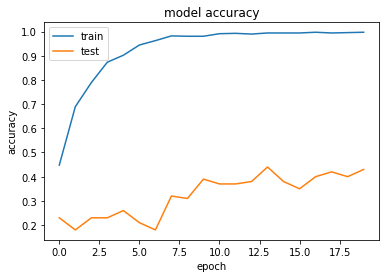

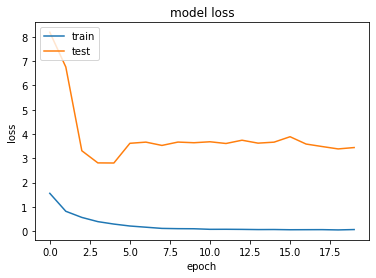

Max. Training Accuracy 0.9969834089279175
Max. Validaiton Accuracy 0.4399999976158142


In [15]:
plot_loss_accuracy(model1_history)

### Model 2: Frames-30, Epocs-30, Batch size-32

In [16]:
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 32
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
num_images = num_frames
height = 120
width = 120

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=(num_images, height, width, 3)),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")

optimizer = tf.keras.optimizers.Adam() #write your optimizer
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model2.summary())

# epochs = 30
# batch size = 32
# num_frames per video = 30
Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 26, 116, 116, 16)  6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 13, 58, 58, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 13, 58, 58, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 11, 56, 56, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 11, 28, 28, 32)   0         
 3D)                                                            

The `steps_per_epoch` and `validation_steps` are used by `fit` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [18]:
model2_history = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5326 - categorical_accuracy: 0.4344
Epoch 00001: val_loss improved from inf to 4.20310, saving model to model_conv3D_2_2024-09-0305_55_43.766329/model-00001-1.53258-0.43439-4.20310-0.23000.h5
21/21 [==============================] - 191s 9s/step - loss: 1.5326 - categorical_accuracy: 0.4344 - val_loss: 4.2031 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9649 - categorical_accuracy: 0.6199
Epoch 00002: val_loss improved from 4.20310 to 2.77362, saving model to model_conv3D_2_2024-09-0305_55_43.766329/model-00002-0.96488-0.61991-2.77362-0.24000.h5
21/21 [==============================] - 189s 9s/step - loss: 0.9649 - categorical_accuracy: 0.6199 - val_loss: 2.7736 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.6249 - categorical_accuracy: 0.7738
Epoch 00003: val_loss improved f

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


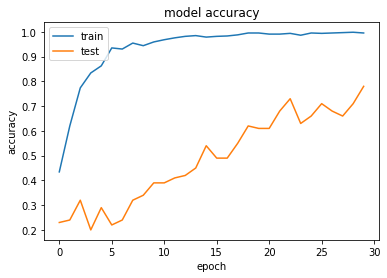

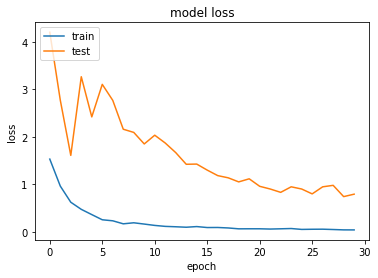

Max. Training Accuracy 0.9984917044639587
Max. Validaiton Accuracy 0.7799999713897705


In [19]:
plot_loss_accuracy(model2_history)

### Model 3: Frames-30, Epocs-20, Base size-32, Reduced parameters

In [20]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 32  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
num_images = num_frames
height = 160
width = 160


model3 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=(num_images, height, width, 3)),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")

optimizer = tf.keras.optimizers.Adam() #write your optimizer
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model3.summary())

# epochs = 20
# batch size = 32
# num_frames per video = 30
Model: "conv_3d3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 15, 80, 80, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 8, 40, 40, 32)    0         
 3D)                                                            

In [21]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [22]:
model3_history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5899 - categorical_accuracy: 0.4389
Epoch 00001: val_loss improved from inf to 2.78303, saving model to model_conv3D_3_2024-09-0305_55_43.766329/model-00001-1.58987-0.43891-2.78303-0.21000.h5
21/21 [==============================] - 215s 10s/step - loss: 1.5899 - categorical_accuracy: 0.4389 - val_loss: 2.7830 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.9013 - categorical_accuracy: 0.6531
Epoch 00002: val_loss did not improve from 2.78303
21/21 [==============================] - 215s 11s/step - loss: 0.9013 - categorical_accuracy: 0.6531 - val_loss: 4.2174 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.6392 - categorical_accuracy: 0.7647
Epoch 00003: val_loss improved from 2.78303 to 2.69835, saving model to model_conv3D_3_2024-09-0305_55_43.766329/model-00003-0.63925-0.7647

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


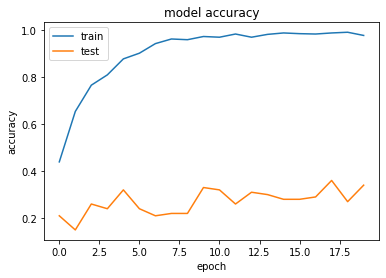

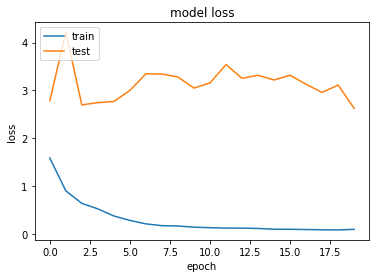

Max. Training Accuracy 0.9894419312477112
Max. Validaiton Accuracy 0.36000001430511475


In [23]:
plot_loss_accuracy(model3_history)

### Model 4: Frames-20, Base size-32, Same pooling in Conv3D layer

In [24]:
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 32  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
num_images = num_frames
height = 120
width = 120

model4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=(num_images, height, width, 3)),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")

optimizer = tf.keras.optimizers.Adam() #write your optimizer
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model4.summary())

# epochs = 30
# batch size = 32
# num_frames per video = 20
Model: "conv_3d4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 10, 60, 60, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 5, 30, 30, 32)    0         
 g3D)                                                           

In [25]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [26]:
model4_history = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.7364 - categorical_accuracy: 0.4314
Epoch 00001: val_loss improved from inf to 1.75053, saving model to model_conv3D_4_2024-09-0305_55_43.766329/model-00001-1.73635-0.43137-1.75053-0.19000.h5
21/21 [==============================] - 121s 6s/step - loss: 1.7364 - categorical_accuracy: 0.4314 - val_loss: 1.7505 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.1121 - categorical_accuracy: 0.6018
Epoch 00002: val_loss did not improve from 1.75053
21/21 [==============================] - 120s 6s/step - loss: 1.1121 - categorical_accuracy: 0.6018 - val_loss: 1.8892 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.9499 - categorical_accuracy: 0.6425
Epoch 00003: val_loss did not improve from 1.75053
21/21 [==============================] - 121s 6s/step - loss: 0.9499 - categorical_accurac

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


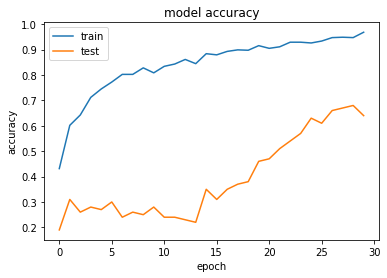

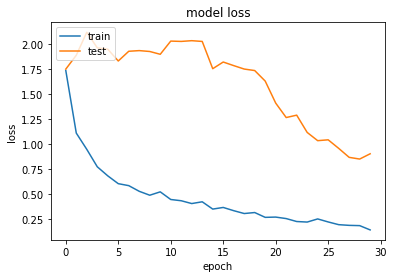

Max. Training Accuracy 0.9683257937431335
Max. Validaiton Accuracy 0.6800000071525574


In [27]:
plot_loss_accuracy(model4_history)

### Model 5: Frames:20, Epocs-20, Batch size-64, switching BatchNormalization before MaxPooling.

In [28]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 64  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
num_images = num_frames
height = 120
width = 120

model5 = Sequential([
    Conv3D(16, make3dFilter(2), padding='same', activation='relu', input_shape=(num_images, height, width, 3)),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2)),

    Conv3D(32, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    
    Dense(128, activation='relu'),
    
    Dense(5, activation='softmax')
], name="conv_3d5")

optimizer = tf.keras.optimizers.Adam() #write your optimizer
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model5.summary())

# epochs = 20
# batch size = 64
# num_frames per video = 20
Model: "conv_3d5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 20, 120, 120, 16)  400       
                                                                 
 batch_normalization_21 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 10, 60, 60, 32)    4128      
                                                                 
 batch_normalization_22 (Bat  (None, 10, 60, 60, 32)   128       
 chNormalization)                                               

In [29]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [30]:
model5_history = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 4.6994 - categorical_accuracy: 0.2836
Epoch 00001: val_loss improved from inf to 1.55075, saving model to model_conv3D_5_2024-09-0305_55_43.766329/model-00001-4.69943-0.28356-1.55075-0.25000.h5
11/11 [==============================] - 109s 11s/step - loss: 4.6994 - categorical_accuracy: 0.2836 - val_loss: 1.5507 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.4126 - categorical_accuracy: 0.5053
Epoch 00002: val_loss did not improve from 1.55075
11/11 [==============================] - 102s 10s/step - loss: 1.4126 - categorical_accuracy: 0.5053 - val_loss: 2.4526 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.9601 - categorical_accuracy: 0.6199
Epoch 00003: val_loss did not improve from 1.55075
11/11 [==============================] - 105s 11s/step - loss: 0.9601 - categorical_accu

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


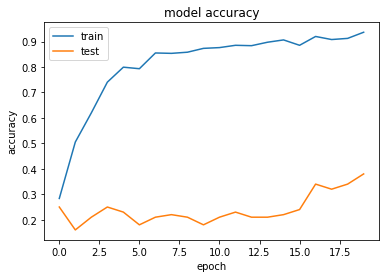

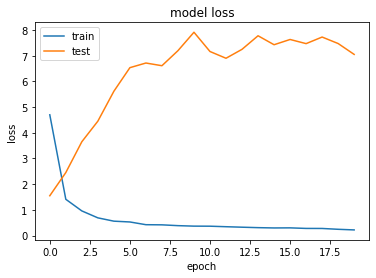

Max. Training Accuracy 0.9366515874862671
Max. Validaiton Accuracy 0.3799999952316284


In [31]:
plot_loss_accuracy(model5_history)

### Model 6: Switching Model architecture to Conv2D+LSTM

In [32]:
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 32  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
num_images = num_frames
height = 120
width = 120

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=(num_images, height, width, 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

optimizer = tf.keras.optimizers.Adam() #write your optimizer
model6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model6.summary())

# epochs = 30
# batch size = 32
# num_frames per video = 20
Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                            

In [33]:
callbacks_list = model_callbacks("model6_Conv2D_LSTM")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [34]:
model6_history = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.3987 - categorical_accuracy: 0.4027
Epoch 00001: val_loss improved from inf to 1.64381, saving model to model6_Conv2D_LSTM_2024-09-0305_55_43.766329/model-00001-1.39871-0.40271-1.64381-0.18000.h5
21/21 [==============================] - 111s 5s/step - loss: 1.3987 - categorical_accuracy: 0.4027 - val_loss: 1.6438 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9695 - categorical_accuracy: 0.6063
Epoch 00002: val_loss did not improve from 1.64381
21/21 [==============================] - 110s 5s/step - loss: 0.9695 - categorical_accuracy: 0.6063 - val_loss: 1.9252 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.8532 - categorical_accuracy: 0.6591
Epoch 00003: val_loss did not improve from 1.64381
21/21 [==============================] - 106s 5s/step - loss: 0.8532 - categorical_acc

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


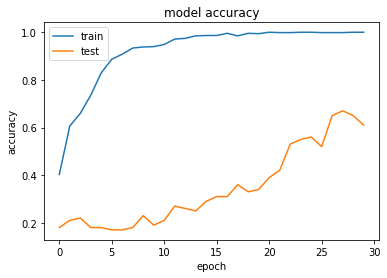

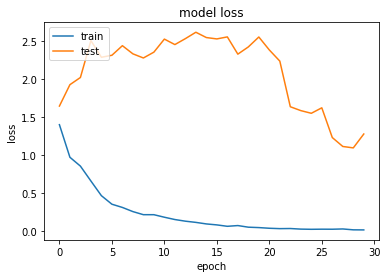

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.6700000166893005


In [35]:
plot_loss_accuracy(model6_history)

### Model 7: Transfer Learning (MobileNet) with LSTM

In [36]:
from tensorflow.keras.applications import mobilenet

In [37]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 64  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
num_images = num_frames
height = 120
width = 120

model7 = Sequential([
    TimeDistributed(mobilenet, input_shape=(num_images, height, width, 3))
], name="mobilenet_lstm")

for layer in model7.layers:
    layer.trainable = False

model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model7.add(TimeDistributed(Flatten()))

model7.add(LSTM(256))
model7.add(Dropout(0.2))

model7.add(Dense(256,activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.Adam() #write your optimizer
model7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model7.summary())

17235968/17225924 [==============================] - 22s 1us/step
# epochs = 30
# batch size = 64
# num_frames per video = 20
Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 1024)         0         
 stributed)                                               

In [38]:
callbacks_list = model_callbacks("model7_transferLearning_LSTM")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [39]:
model7_history = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.4373 - categorical_accuracy: 0.4057
Epoch 00001: val_loss improved from inf to 1.21476, saving model to model7_transferLearning_LSTM_2024-09-0305_55_43.766329/model-00001-1.43728-0.40573-1.21476-0.52000.h5
11/11 [==============================] - 114s 11s/step - loss: 1.4373 - categorical_accuracy: 0.4057 - val_loss: 1.2148 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.6906 - categorical_accuracy: 0.7873
Epoch 00002: val_loss improved from 1.21476 to 0.77453, saving model to model7_transferLearning_LSTM_2024-09-0305_55_43.766329/model-00002-0.69063-0.78733-0.77453-0.72000.h5
11/11 [==============================] - 104s 10s/step - loss: 0.6906 - categorical_accuracy: 0.7873 - val_loss: 0.7745 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.3121 - categorical_accuracy: 0.9125
Ep

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


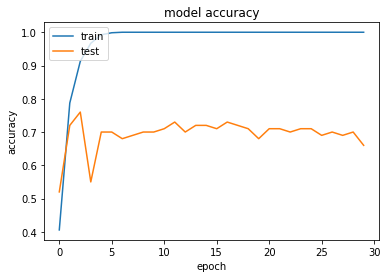

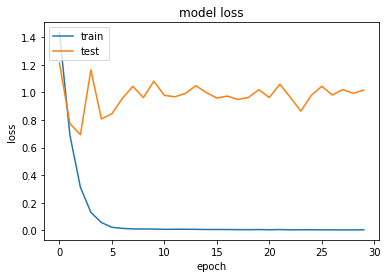

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.7599999904632568


In [40]:
plot_loss_accuracy(model7_history)

### Model 8: Switching Model architecture to Conv2D+GRU

In [41]:
from keras.applications import mobilenet

In [ ]:
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 32  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
num_images = num_frames
height = 120
width = 120

model8 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=(num_images, height, width, 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_gru")

optimizer = tf.keras.optimizers.Adam() #write your optimizer
model8.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model8.summary())

# epochs = 30
# batch size = 32
# num frames per video = 20
Model: "conv_2d_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                             

In [ ]:
callbacks_list = model_callbacks("model8_Conv2D_GRU")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
model8_history = model8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.3652 - categorical_accuracy: 0.4344
Epoch 00001: val_loss improved from inf to 1.55969, saving model to model8_Conv2D_GRU_2024-09-0305_55_43.766329/model-00001-1.36521-0.43439-1.55969-0.30000.h5
21/21 [==============================] - 106s 5s/step - loss: 1.3652 - categorical_accuracy: 0.4344 - val_loss: 1.5597 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.8266 - categorical_accuracy: 0.6848
Epoch 00002: val_loss did not improve from 1.55969
21/21 [==============================] - 104s 5s/step - loss: 0.8266 - categorical_accuracy: 0.6848 - val_loss: 2.3386 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.6142 - categorical_accuracy: 0.7421
Epoch 00003: val_loss did not improve from 1.55969
21/21 [==============================] - 104s 5s/step - loss: 0.6142 - categorical_accu

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


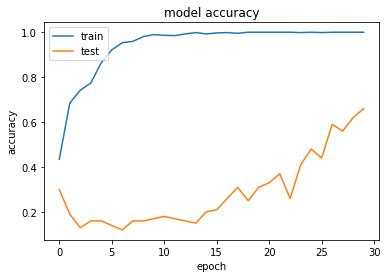

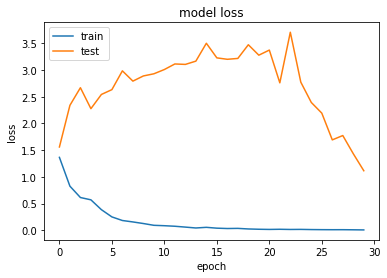

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.6600000262260437


In [ ]:
plot_loss_accuracy(model8_history)

### Model 9: Transfer Learning (MobileNet) with GRU

In [55]:
from tensorflow.keras.applications import mobilenet

mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 32  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
num_images = num_frames

height = 120
width = 120

model9 = Sequential([
    TimeDistributed(mobilenet, input_shape=(num_images, height, width, 3))
], name="mobilenet_lstm")

for layer in model7.layers:
    layer.trainable = False

model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model9.add(TimeDistributed(Flatten()))

model9.add(GRU(256))
model9.add(Dropout(0.2))

model9.add(Dense(256,activation='relu'))
model9.add(Dropout(0.2))

model9.add(Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.Adam() #write your optimizer
model9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model9.summary())

# epochs = 30
# batch size = 32
# num frames per video = 20
Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                          

In [56]:
callbacks_list = model_callbacks("model9_transferLearning_GRU")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [57]:
model9_history = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.1202 - categorical_accuracy: 0.5460
Epoch 00001: val_loss improved from inf to 0.93827, saving model to model9_transferLearning_GRU_2024-09-0305_55_43.766329/model-00001-1.12021-0.54600-0.93827-0.58000.h5
21/21 [==============================] - 126s 6s/step - loss: 1.1202 - categorical_accuracy: 0.5460 - val_loss: 0.9383 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.3608 - categorical_accuracy: 0.8658
Epoch 00002: val_loss improved from 0.93827 to 0.71114, saving model to model9_transferLearning_GRU_2024-09-0305_55_43.766329/model-00002-0.36077-0.86576-0.71114-0.69000.h5
21/21 [==============================] - 122s 6s/step - loss: 0.3608 - categorical_accuracy: 0.8658 - val_loss: 0.7111 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.1398 - categorical_accuracy: 0.9502
Epoch 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


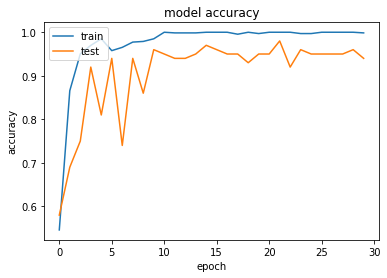

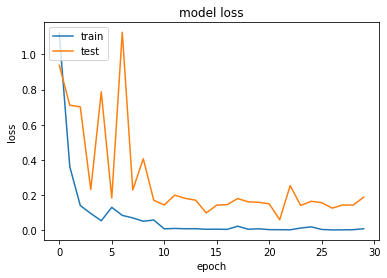

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.9800000190734863


In [58]:
plot_loss_accuracy(model9_history)